# APA Laboratori 8 - Random Forests             

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade 
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install statsmodels --upgrade
# !pip install scikit-learn --upgrade
#!pip install imblearn --upgrade 
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Extra imports
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
def confusion(true, pred, classes):
    """
    Function for pretty printing confusion matrices
    """
    cm =pd.DataFrame(confusion_matrix(true, pred), index=classes,
                 columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    return cm

In [5]:
np.random.seed(6046)

## Financial Example: classification model for deposit subscription

Direct marketing campaigns (phone calls) of a Portuguese banking institution. 
 The classification goal is to predict if the client will subscribe a term deposit

In [6]:
deposit = read_csv("bank-full.csv.gz", header=0, delimiter=';')
deposit.shape

(45211, 17)

In [7]:
deposit.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000,45211,45211,45211,45211,45211.000,45211,45211,45211,45211.000,45211,45211.000,45211.000,45211.000,45211.000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936,NaN,NaN,NaN,NaN,1362.272,NaN,NaN,NaN,15.806,NaN,258.163,2.764,40.198,0.580,NaN,NaN
std,10.619,NaN,NaN,NaN,NaN,3044.766,NaN,NaN,NaN,8.322,NaN,257.528,3.098,100.129,2.303,NaN,NaN
min,18.000,NaN,NaN,NaN,NaN,-8019.000,NaN,NaN,NaN,1.000,NaN,0.000,1.000,-1.000,0.000,NaN,NaN
25%,33.000,NaN,NaN,NaN,NaN,72.000,NaN,NaN,NaN,8.000,NaN,103.000,1.000,-1.000,0.000,NaN,NaN
50%,39.000,NaN,NaN,NaN,NaN,448.000,NaN,NaN,NaN,16.000,NaN,180.000,2.000,-1.000,0.000,NaN,NaN
75%,48.000,NaN,NaN,NaN,NaN,1428.000,NaN,NaN,NaN,21.000,NaN,319.000,3.000,-1.000,0.000,NaN,NaN


 This dataset needs a lot of pre-processing ... also it displays a good mixture of categorical and numeric variables

 age seems OK
 job has 12 values, let's check their frequency

 seems OK

In [8]:
deposit.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

education has 4 values, let's check their frequency

 seems OK

In [9]:
deposit.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

 month looks very suspicious ... but is OK

In [10]:
deposit.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

Duration is highly skewed ...

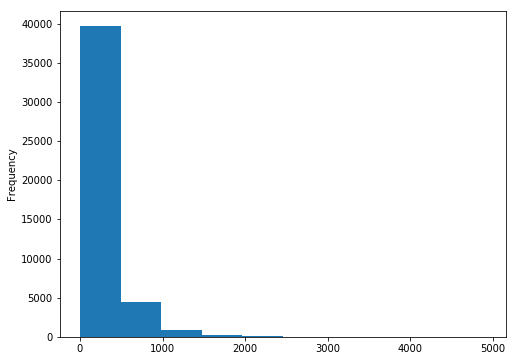

In [11]:
deposit.duration.plot.hist(figsize=(8,6));

/usr/local/lib64/python3.6/site-packages/pandas/core/base.py:315: RuntimeWarning: divide by zero encountered in log
  return f(self, *args, **kwargs)


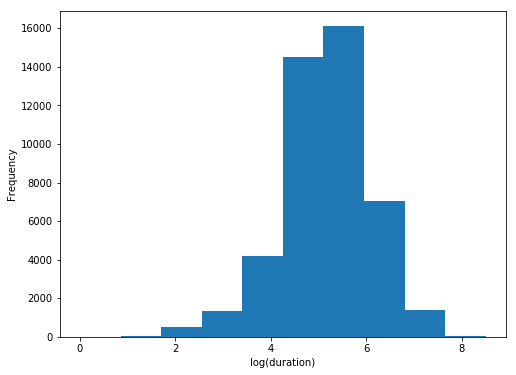

In [12]:
pd.set_option('use_inf_as_na', True)
ax = deposit.duration.apply('log').dropna().plot.hist(figsize=(8,6))
plt.xlabel('log(duration)');


In [13]:
deposit['duration'] = deposit.duration.apply(lambda x: np.log(x+0.001))

 what to do with 'pdays' and 'previous'? it is not clear how to best pre-process them; we shall need
 some financial expertise... we leave them as they are

 The rest seem OK (but it would take a careful analysis, and a lot of domain knowledge)

Let's rename the target ...

In [14]:
deposit.rename({'y':'subscribe'}, axis='columns',inplace=True)
deposit.shape

(45211, 17)

In [15]:
deposit.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
count,45211.000,45211,45211,45211,45211,45211.000,45211,45211,45211,45211.000,45211,45211.000,45211.000,45211.000,45211.000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936,NaN,NaN,NaN,NaN,1362.272,NaN,NaN,NaN,15.806,NaN,5.162,2.764,40.198,0.580,NaN,NaN
std,10.619,NaN,NaN,NaN,NaN,3044.766,NaN,NaN,NaN,8.322,NaN,0.938,3.098,100.129,2.303,NaN,NaN
min,18.000,NaN,NaN,NaN,NaN,-8019.000,NaN,NaN,NaN,1.000,NaN,-6.908,1.000,-1.000,0.000,NaN,NaN
25%,33.000,NaN,NaN,NaN,NaN,72.000,NaN,NaN,NaN,8.000,NaN,4.635,1.000,-1.000,0.000,NaN,NaN
50%,39.000,NaN,NaN,NaN,NaN,448.000,NaN,NaN,NaN,16.000,NaN,5.193,2.000,-1.000,0.000,NaN,NaN
75%,48.000,NaN,NaN,NaN,NaN,1428.000,NaN,NaN,NaN,21.000,NaN,5.765,3.000,-1.000,0.000,NaN,NaN


Scikit learn decision trees classifier do not handle categorical attributes so we have to transform them to numerical

In [16]:
for v in deposit.columns:
    if deposit[v].dtype.kind == 'O':
        deposit[v] = LabelEncoder().fit_transform(deposit[v])

deposit.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
0,58,4,1,2,0,2143,1,0,2,5,8,5.565,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,5.017,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,4.331,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,4.522,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,5.288,1,-1,0,3,0


precalculate the TR/TE partition and the cross-validation partitions on the TR part

In [17]:
train, test = train_test_split(deposit, test_size=1/3)

First try a standard decision tree. 


In [18]:
model_tree = DecisionTreeClassifier().fit(train.loc[:,:'poutcome'], 
                                          train.subscribe)


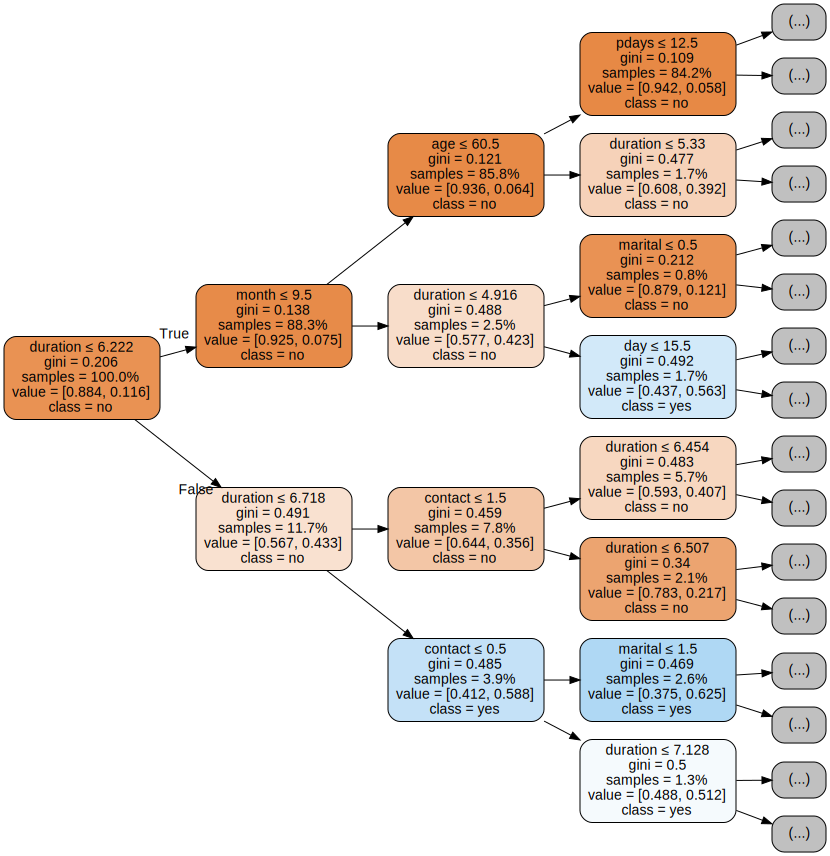

In [19]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=deposit.columns[:-1],  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
graph = graphviz.Source(dot_data)  
graph 

In [20]:
pred = model_tree.predict(test.loc[:,:'poutcome'])

confusion(test.subscribe,pred,['no','yes'])


Predicted,no,yes
Actual,,
no,12216,1073
yes,943,839


prediction error

In [21]:
(1-accuracy_score(test.subscribe,pred))*100

13.376683697166747

F1 score

In [22]:
f1_score(test.subscribe,pred)

0.45425013535462916

From the detailed report we can see that the classification for the class `yes` is not very good

In [23]:
print(classification_report(test.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

             precision    recall  f1-score   support

         no       0.93      0.92      0.92     13289
        yes       0.44      0.47      0.45      1782

avg / total       0.87      0.87      0.87     15071



***

 Now a random Forest

In [24]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(train.loc[:,:'poutcome'],
                                                       train.subscribe)

pred = model_rf1.predict(train.loc[:,:'poutcome'])

confusion(train.subscribe,pred, ['no','yes'])

print(classification_report(train.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

print('OOB error=', 1-model_rf1.oob_score_)

/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Predicted,no,yes
Actual,,
no,26628,5
yes,247,3260


             precision    recall  f1-score   support

         no       0.99      1.00      1.00     26633
        yes       1.00      0.93      0.96      3507

avg / total       0.99      0.99      0.99     30140

OOB error= 0.10776376907763774


We get now a better estimated test error (OOB)

let's compute the real test error:

In [25]:
pred = model_rf1.predict(test.loc[:,:'poutcome'])

confusion(test.subscribe,pred, ['no','yes'])

Predicted,no,yes
Actual,,
no,12890,399
yes,1095,687


Error

In [26]:
(1-accuracy_score(test.subscribe,pred))*100

9.9130780970075

F1 score

In [27]:
f1_score(test.subscribe,pred)

0.4790794979079498

In [28]:
print(classification_report(test.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

             precision    recall  f1-score   support

         no       0.92      0.97      0.95     13289
        yes       0.63      0.39      0.48      1782

avg / total       0.89      0.90      0.89     15071



So OOB really works in estimating prediction error and the RF is better than a single tree; 
 however, there is a big issue in unbalanced classes

 one way to deal with this is to include class weights

In [29]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight={0:1,1:10}).fit(train.loc[:,:'poutcome'],
                                                                train.subscribe)


pred = model_rf2.predict(train.loc[:,:'poutcome'])

confusion(train.subscribe,pred, ['no','yes'])

print(classification_report(train.subscribe,pred,target_names=['no', 'yes'],))

print('OOB error=', 1- model_rf2.oob_score_)

Predicted,no,yes
Actual,,
no,26633,0
yes,1,3506


             precision    recall  f1-score   support

         no       1.00      1.00      1.00     26633
        yes       1.00      1.00      1.00      3507

avg / total       1.00      1.00      1.00     30140

OOB error= 0.10066357000663573


which helps a little bit, but not much:  with a better balance; let's compute the real test error:

In [30]:
pred = model_rf2.predict(test.loc[:,:'poutcome'])

confusion(test.subscribe,pred,['no','yes'])

Predicted,no,yes
Actual,,
no,12996,293
yes,1178,604


In [31]:
(1-accuracy_score(test.subscribe,pred))*100

9.760467122287842

In [32]:
f1_score(test.subscribe,pred)

0.4509145203434118

In [33]:
print(classification_report(test.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

             precision    recall  f1-score   support

         no       0.92      0.98      0.95     13289
        yes       0.67      0.34      0.45      1782

avg / total       0.89      0.90      0.89     15071



 another way is to balance the sampling in the boostrap resamples

 'no' is the more represented class, so we down sample it
 
scikit-learn does not provide resample algorithms, but we can use the imbalanced-learn library that provides many strategies for kind of problem.

We resample the training so the number of `yes` examples equals the number of `no` examples

In [34]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(train.loc[:,:'poutcome'], 
                                          train.subscribe)
X_resampled.shape

(7014, 16)

In [35]:
model_rf3 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True).fit(X_resampled, 
                                                       y_resampled)

pred = model_rf3.predict(train.loc[:,:'poutcome'])

confusion(train.subscribe,pred, ['no','yes'])

print(classification_report(train.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

print('OOB error=', 1- model_rf3.oob_score_)

Predicted,no,yes
Actual,,
no,22574,4059
yes,0,3507


             precision    recall  f1-score   support

         no       1.00      0.85      0.92     26633
        yes       0.46      1.00      0.63      3507

avg / total       0.94      0.87      0.88     30140

OOB error= 0.14556601083547194


which seems to help much more for balancing the `yes` class

 let's compute the real test error:

In [36]:
pred = model_rf3.predict(test.loc[:,:'poutcome'])

confusion(test.subscribe,pred, ['no','yes'])

Predicted,no,yes
Actual,,
no,10921,2368
yes,200,1582


In [37]:
(1-accuracy_score(test.subscribe,pred))*100

17.039347090438596

In [38]:
f1_score(test.subscribe,pred)

0.5519888346127005

In [39]:
print(classification_report(test.subscribe,
                            pred,
                            target_names=['no', 'yes'],))

             precision    recall  f1-score   support

         no       0.98      0.82      0.89     13289
        yes       0.40      0.89      0.55      1782

avg / total       0.91      0.83      0.85     15071



 Now we can try to optimize the number of trees, guided by OOB:

In [40]:
ntrees = np.array(np.round(10**np.arange(1,3.1,0.2)),dtype=int)
ntrees

array([  10,   16,   25,   40,   63,  100,  158,  251,  398,  631, 1000])

In [41]:
rf_results= []
for nt in ntrees:
    model_rf = RandomForestClassifier(n_estimators=nt, 
                                      oob_score=True).fit(X_resampled, y_resampled)
    rf_results.append(1-model_rf.oob_score_)

rf_results = pd.DataFrame({'ntrees':ntrees, 'OOB':rf_results})

/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [42]:
rf_results

,ntrees,OOB
0,10,0.210
1,16,0.175
2,25,0.172
3,40,0.157
4,63,0.150
5,100,0.150
6,158,0.148
7,251,0.147
8,398,0.146
9,631,0.145


 choose best value of 'ntrees'

In [43]:
rf_results.loc[rf_results.OOB.idxmin]

ntrees    631.000
OOB         0.145
Name: 9, dtype: float64

we could also try to optimize the number of variables in the same way, though the default values work quite well in general

Now refit the RF with the best value of 'ntrees'

In [44]:
model_rf = RandomForestClassifier(n_estimators=rf_results.ntrees.loc[rf_results.OOB.idxmin], 
                                  oob_score=True).fit(X_resampled, 
                                                      y_resampled)

 let's compute the real test error:

In [45]:
pred = model_rf.predict(test.loc[:,:'poutcome'])

confusion(test.subscribe,pred, ['no','yes'])

Predicted,no,yes
Actual,,
no,10883,2406
yes,198,1584


In [46]:
(1-accuracy_score(test.subscribe,pred))*100

17.27821644217371

In [47]:
f1_score(test.subscribe,pred)

0.5488565488565488

In [48]:
print(classification_report(test.subscribe,
                            pred,
                            target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.98      0.82      0.89     13289
        yes       0.40      0.89      0.55      1782

avg / total       0.91      0.83      0.85     15071



 The importance of variables

In [49]:
var_imp = pd.DataFrame({'importance': model_rf.feature_importances_},
                       index=deposit.columns[:-1])

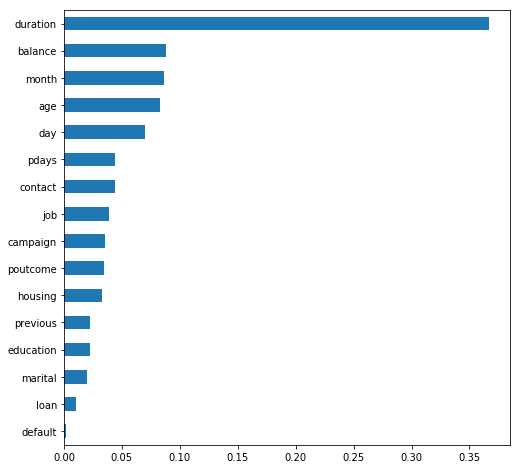

In [50]:
var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

 'duration' is the most important variable

 plot error rate: black = out of bag (OOB), red = label 1 ('no'), green  = label 2 ('yes')
 as a function of the number of trees used

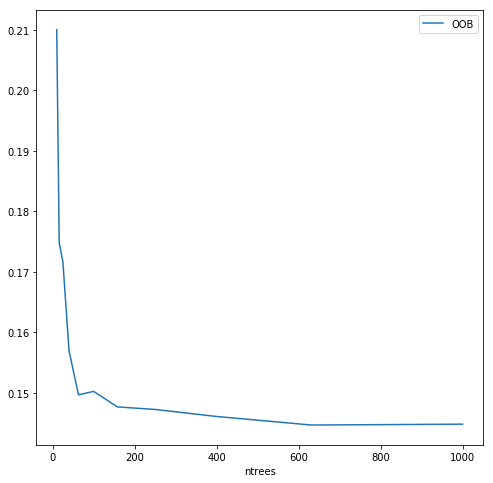

In [51]:
rf_results.plot(x='ntrees',y='OOB',figsize=(8,8));